## 1. Create Neural Network Model

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Small
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import time
import json

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.model_selection import train_test_split
import shutil

In [2]:
train_path = 'bears_dataset/train'
valid_path = 'bears_dataset/valid'
test_path = 'bears_dataset/test'

In [3]:
breeds = [
    "black", "grizzly", "panda", "polar", "sloth", "sun"
]

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(224,224), classes=breeds, batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(224,224), classes=breeds, batch_size = 10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=test_path, target_size=(224,224), classes=breeds, batch_size = 10, shuffle=False)


Found 2400 images belonging to 6 classes.
Found 300 images belonging to 6 classes.
Found 300 images belonging to 6 classes.


In [4]:
from PIL import Image
import os

def check_invalid_images(directory):
    invalid_images = []
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            try:
                img = Image.open(os.path.join(subdir, file))
                img.verify()  # Verifies if the image is corrupted
            except (IOError, SyntaxError) as e:
                invalid_images.append(os.path.join(subdir, file))
    return invalid_images

# Check for invalid images in the 'bears_dataset' directory
invalid_images = check_invalid_images("bears_dataset")
if invalid_images:
    print("Found invalid images:")
    for img in invalid_images:
        print(img)
else:
    print("All images are valid.")

Found invalid images:
bears_dataset/.DS_Store
bears_dataset/valid/.DS_Store
bears_dataset/test/.DS_Store
bears_dataset/train/.DS_Store


## 2. Model Training

In [5]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

2025-06-12 01:38:43.486721: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-06-12 01:38:43.486935: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-12 01:38:43.486960: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-12 01:38:43.487200: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-12 01:38:43.487224: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
for layer in resnet_model.layers:
    layer.trainable = False

for layer in densenet_model.layers:
    layer.trainable = False

for layer in mobilenet_model.layers:
    layer.trainable = False

<h3>Build Model</h3>

In [7]:
def build_model(base_model):
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Add pooling layer
        Dense(1024, activation='relu'),  # Add dense layer
        Dense(len(breeds), activation='softmax')  # Number of classes
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy',])
    return model
    
resnet_final_model = build_model(resnet_model)
densenet_final_model = build_model(densenet_model)
mobilenet_final_model = build_model(mobilenet_model)


<h3>ResNet50 Model</h3>

In [8]:
resnet_final_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,692,038 (98.01 MB)

 Trainable params: 2,104,326 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
import time
import json

# Track the time
start_time = time.time()

# Train the model
resnet_history = resnet_final_model.fit(
    train_batches,
    epochs=50,
    validation_data=valid_batches
)


end_time = time.time()
training_time_resnet = end_time - start_time
print(f"Training Time for ResNet50: {training_time_resnet:.2f} seconds")

# Save  trained model
resnet_final_model.save('resnet50_model.h5')
print("ResNet50 model saved as 'resnet50_model.h5'")

# include training time
resnet_history_dict = resnet_history.history
resnet_history_dict["training_time"] = training_time_resnet

# Save the history to a JSON file
with open("resnet_history.json", "w") as json_file:
    json.dump(resnet_history_dict, json_file)

print("ResNet50 training history and time saved to 'resnet_history.json'")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2025-06-12 01:39:38.337441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-06-12 01:39:38.342202: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7950 - loss: 0.8264

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 45s 159ms/step - accuracy: 0.7953 - loss: 0.8249 - val_accuracy: 0.9367 - val_loss: 0.2297
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 38s 158ms/step - accuracy: 0.9307 - loss: 0.1996 - val_accuracy: 0.9300 - val_loss: 0.2348
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 38s 160ms/step - accuracy: 0.9580 - loss: 0.1402 - val_accuracy: 0.9067 - val_loss: 0.3088
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 38s 159ms/step - accuracy: 0.9621 - loss: 0.1111 - val_accuracy: 0.9400 - val_loss: 0.2198
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 41s 170ms/step - accuracy: 0.9529 - loss: 0.1217 - val_accuracy: 0.9433 - val_loss: 0.2554
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 43s 178ms/step - accuracy: 0.9650 - loss: 0.0919 - val_accuracy: 0.9200 - val_loss: 0.2935
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 44s 183ms/step - accuracy: 0.9717 - loss: 0.0830 - val_accuracy: 0.9133 - val_loss: 0.3709
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 44s 183ms/step - accuracy: 0.9678 - loss: 0.0921 - val

Training Time for ResNet50: 2351.29 seconds
ResNet50 model saved as 'resnet50_model.h5'
ResNet50 training history and time saved to 'resnet_history.json'


<h3>ResNet50 Performance (accuracy and mAP)</h3>

In [11]:
test_loss_resnet, test_accuracy_resnet = resnet_final_model.evaluate(test_batches)

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9716 - loss: 0.2112


In [12]:
print(f"ResNet50 Test Accuracy: {test_accuracy_resnet}")

ResNet50 Test Accuracy: 0.9433333277702332


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import average_precision_score
import numpy as np

# Generate predictions on test set
y_pred = resnet_final_model.predict(test_batches)
y_true = test_batches.classes  # Ground truth labels

# Convert predictions to class probabilities
y_pred_resnet = np.argmax(y_pred, axis=1)

# Convert ground truth labels to one-hot encoding
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(breeds))

# Compute mAP
mAP = average_precision_score(y_true_one_hot, y_pred, average="macro")


print(f"Test Loss: {test_loss_resnet}")
print(f"Mean Average Precision (mAP): {mAP}")

2025-06-12 02:20:13.196069: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step
Test Loss: 0.42486464977264404
Mean Average Precision (mAP): 0.9706644596716277


<h3>DenseNet121 Model</h3>

In [39]:
densenet_final_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,093,254 (30.87 MB)

 Trainable params: 1,055,750 (4.03 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [40]:
import time
import json

# Track the start time for  training
start_time = time.time()

# Train the model
densenet_history = densenet_final_model.fit(
    train_batches,
    epochs=50,
    validation_data=valid_batches
)

#calculate training duration
end_time = time.time()
training_time_densenet = end_time - start_time
print(f"Training Time for DenseNet121: {training_time_densenet:.2f} seconds")

# Save the trained model
densenet_final_model.save('densenet121_model.h5')
print("DenseNet121 model saved as 'densenet121_model.h5'")

#include training time
densenet_history_dict = densenet_history.history
densenet_history_dict["training_time"] = training_time_densenet

# Save the history to a JSON file
with open("densenet_history.json", "w") as json_file:
    json.dump(densenet_history_dict, json_file)

print("DenseNet121 training history and time saved to 'densenet_history.json'")

Epoch 1/50


2025-06-12 03:01:47.772328: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.4319 - loss: 4.5190

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 48s 166ms/step - accuracy: 0.4322 - loss: 4.5113 - val_accuracy: 0.5567 - val_loss: 1.4407
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 40s 167ms/step - accuracy: 0.6551 - loss: 1.0394 - val_accuracy: 0.6833 - val_loss: 0.9439
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 44s 184ms/step - accuracy: 0.6986 - loss: 0.8406 - val_accuracy: 0.6833 - val_loss: 0.7999
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 51s 212ms/step - accuracy: 0.7381 - loss: 0.7101 - val_accuracy: 0.6833 - val_loss: 0.8984
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 56s 234ms/step - accuracy: 0.7647 - loss: 0.6567 - val_accuracy: 0.6567 - val_loss: 0.8933
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 56s 233ms/step - accuracy: 0.7731 - loss: 0.5946 - val_accuracy: 0.7067 - val_loss: 0.7892
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 55s 230ms/step - accuracy: 0.7978 - loss: 0.5372 - val_accuracy: 0.6767 - val_loss: 0.9909
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 59s 244ms/step - accuracy: 0.8120 - loss: 0.5060 - val

Training Time for DenseNet121: 3212.04 seconds
DenseNet121 model saved as 'densenet121_model.h5'
DenseNet121 training history and time saved to 'densenet_history.json'


<h3>DenseNet121 Performance (accuracy and mAP)</h3>

In [41]:
test_loss_densenet, test_accuracy_densenet = densenet_final_model.evaluate(test_batches)

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.7887 - loss: 1.2460


In [42]:
print(f"DenseNet121 Test Accuracy: {test_accuracy_densenet}")

DenseNet121 Test Accuracy: 0.7433333396911621


In [43]:
y_pred = densenet_final_model.predict(test_batches)
y_pred_densenet = np.argmax(y_pred, axis=1)
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(breeds))
mAP_densenet = average_precision_score(y_true_one_hot, y_pred, average="macro")

2025-06-12 03:55:49.490666: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step


In [44]:
print(f"DenseNet Test Loss: {test_loss_densenet}")
print(f"DenseNet mAP: {mAP_densenet}")

DenseNet Test Loss: 1.670043706893921
DenseNet mAP: 0.7845340840149646


<h2>MobileNetV3 Model</h2>

In [28]:
mobilenet_final_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,730,116 (10.41 MB)

 Trainable params: 596,998 (2.28 MB)

 Non-trainable params: 939,120 (3.58 MB)

 Optimizer params: 1,193,998 (4.55 MB)

In [29]:
import time
import json


mobilenet_final_model = build_model(mobilenet_model)


mobilenet_final_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Track the start time for  training
start = time.time()

# Train model
history_mobilenet = mobilenet_final_model.fit(
    train_batches,
    epochs=50,
    validation_data=valid_batches
)

#alculate training duration
end = time.time()
training_time_mobilenet = end - start
print(f"Training Time for MobileNetV3: {training_time_mobilenet:.2f} seconds")

# Save rained model
mobilenet_final_model.save('mobilenetv3_model.h5')
print("MobileNetV3 model saved as 'mobilenetv3_model.h5'")

#include training time
mobilenet_history_dict = history_mobilenet.history
mobilenet_history_dict["training_time"] = training_time_mobilenet

# Save the history to a JSON file
with open("mobilenet_history.json", "w") as json_file:
    json.dump(mobilenet_history_dict, json_file)

print("MobileNetV3 training history and time saved to 'mobilenet_history.json'")

Epoch 1/50


2025-06-12 02:39:14.688564: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7218 - loss: 0.7625

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - accuracy: 0.7221 - loss: 0.7617 - val_accuracy: 0.8633 - val_loss: 0.4115
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 25s 103ms/step - accuracy: 0.8898 - loss: 0.3113 - val_accuracy: 0.8500 - val_loss: 0.3958
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.9116 - loss: 0.2457 - val_accuracy: 0.9067 - val_loss: 0.3142
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 25s 103ms/step - accuracy: 0.9342 - loss: 0.1921 - val_accuracy: 0.8833 - val_loss: 0.3733
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - accuracy: 0.9439 - loss: 0.1556 - val_accuracy: 0.9033 - val_loss: 0.3190
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - accuracy: 0.9545 - loss: 0.1274 - val_accuracy: 0.8933 - val_loss: 0.3383
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - accuracy: 0.9656 - loss: 0.1053 - val_accuracy: 0.8833 - val_loss: 0.4558
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - accuracy: 0.9584 - loss: 0.1132 - val

Training Time for MobileNetV3: 1219.77 seconds
MobileNetV3 model saved as 'mobilenetv3_model.h5'
MobileNetV3 training history and time saved to 'mobilenet_history.json'


<h3>MobileNetV3 Performance (accuracy and mAP)</h3>

In [30]:
test_loss_mobilenet, test_accuracy_mobilenet = mobilenet_final_model.evaluate(test_batches)

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9061 - loss: 0.5346


In [32]:
print(f"MobileNetV3 Test Accuracy: {test_accuracy_mobilenet}")

MobileNetV3 Test Accuracy: 0.8933333158493042


In [33]:
y_pred = mobilenet_final_model.predict(test_batches)
y_pred_mobilenet = np.argmax(y_pred, axis=1)
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(breeds))
mAP_mobilenet = average_precision_score(y_true_one_hot, y_pred, average="macro")

2025-06-12 03:00:19.566312: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step


In [34]:
print(f"MobileNet Test Loss: {test_loss_mobilenet}")
print(f"MobileNet mAP: {mAP_mobilenet}")

MobileNet Test Loss: 0.6731778979301453
MobileNet mAP: 0.9393137365208819


Class Names: ['black', 'grizzly', 'panda', 'polar', 'sloth', 'sun']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


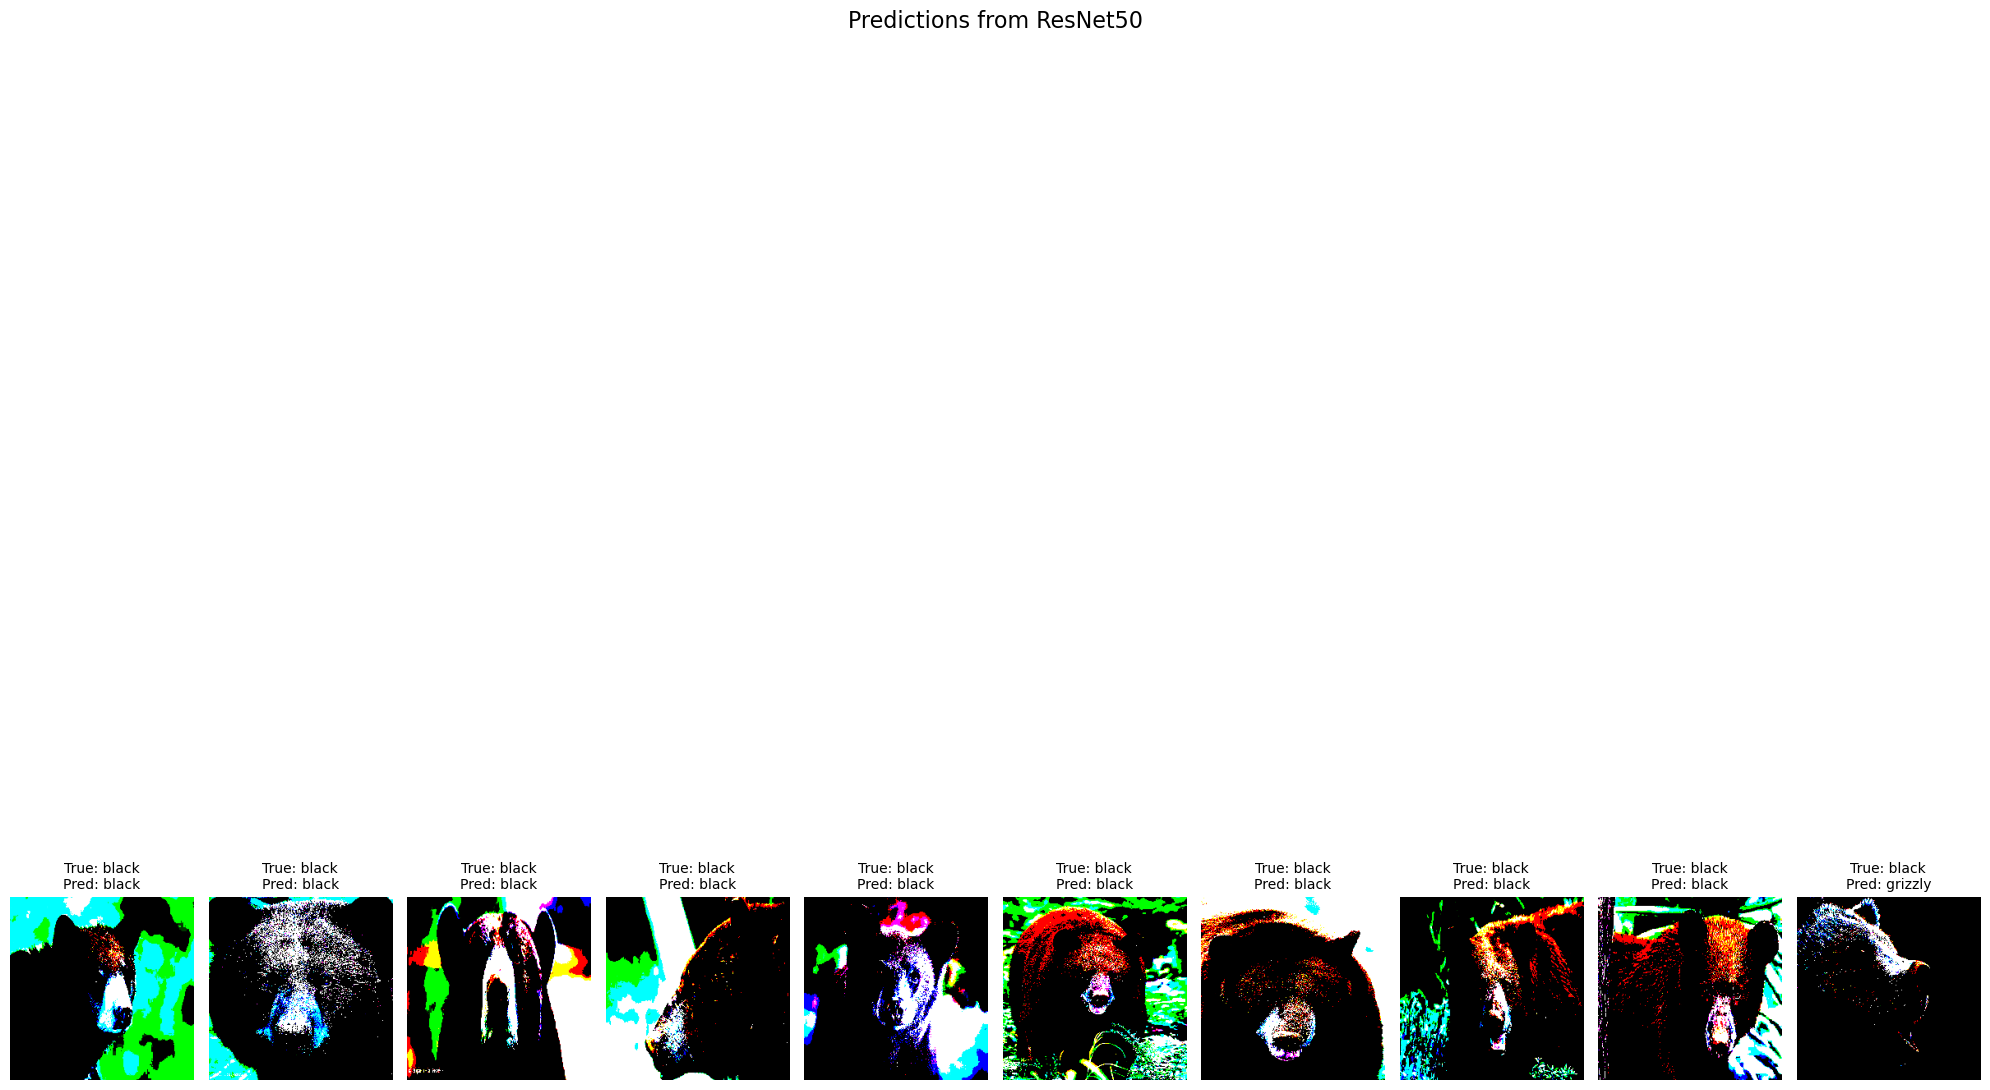

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot images with predictions
def plotImagesWithPredictions(images_arr, true_labels, predicted_labels, model_name):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, true_label, pred_label, ax in zip(images_arr, true_labels, predicted_labels, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.suptitle(f"Predictions from {model_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Fetch a batch of test images and labels
test_imgs, test_labels = next(test_batches)

# Convert test_labels from one-hot encoding to class indices for readability
true_labels = np.argmax(test_labels, axis=1)
breeds = sorted(list(breeds))  # Guarantee class order
class_names = breeds  # Use this consistently
print("Class Names:", class_names)
# RESNET Predictions
y_pred = resnet_final_model.predict(test_imgs)
y_pred_resnets = np.argmax(y_pred, axis=1)
plotImagesWithPredictions(test_imgs, 
                          [class_names[i] for i in true_labels], 
                          [class_names[i] for i in y_pred_resnets], 
                          model_name="ResNet50")


2025-06-12 03:57:53.239681: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


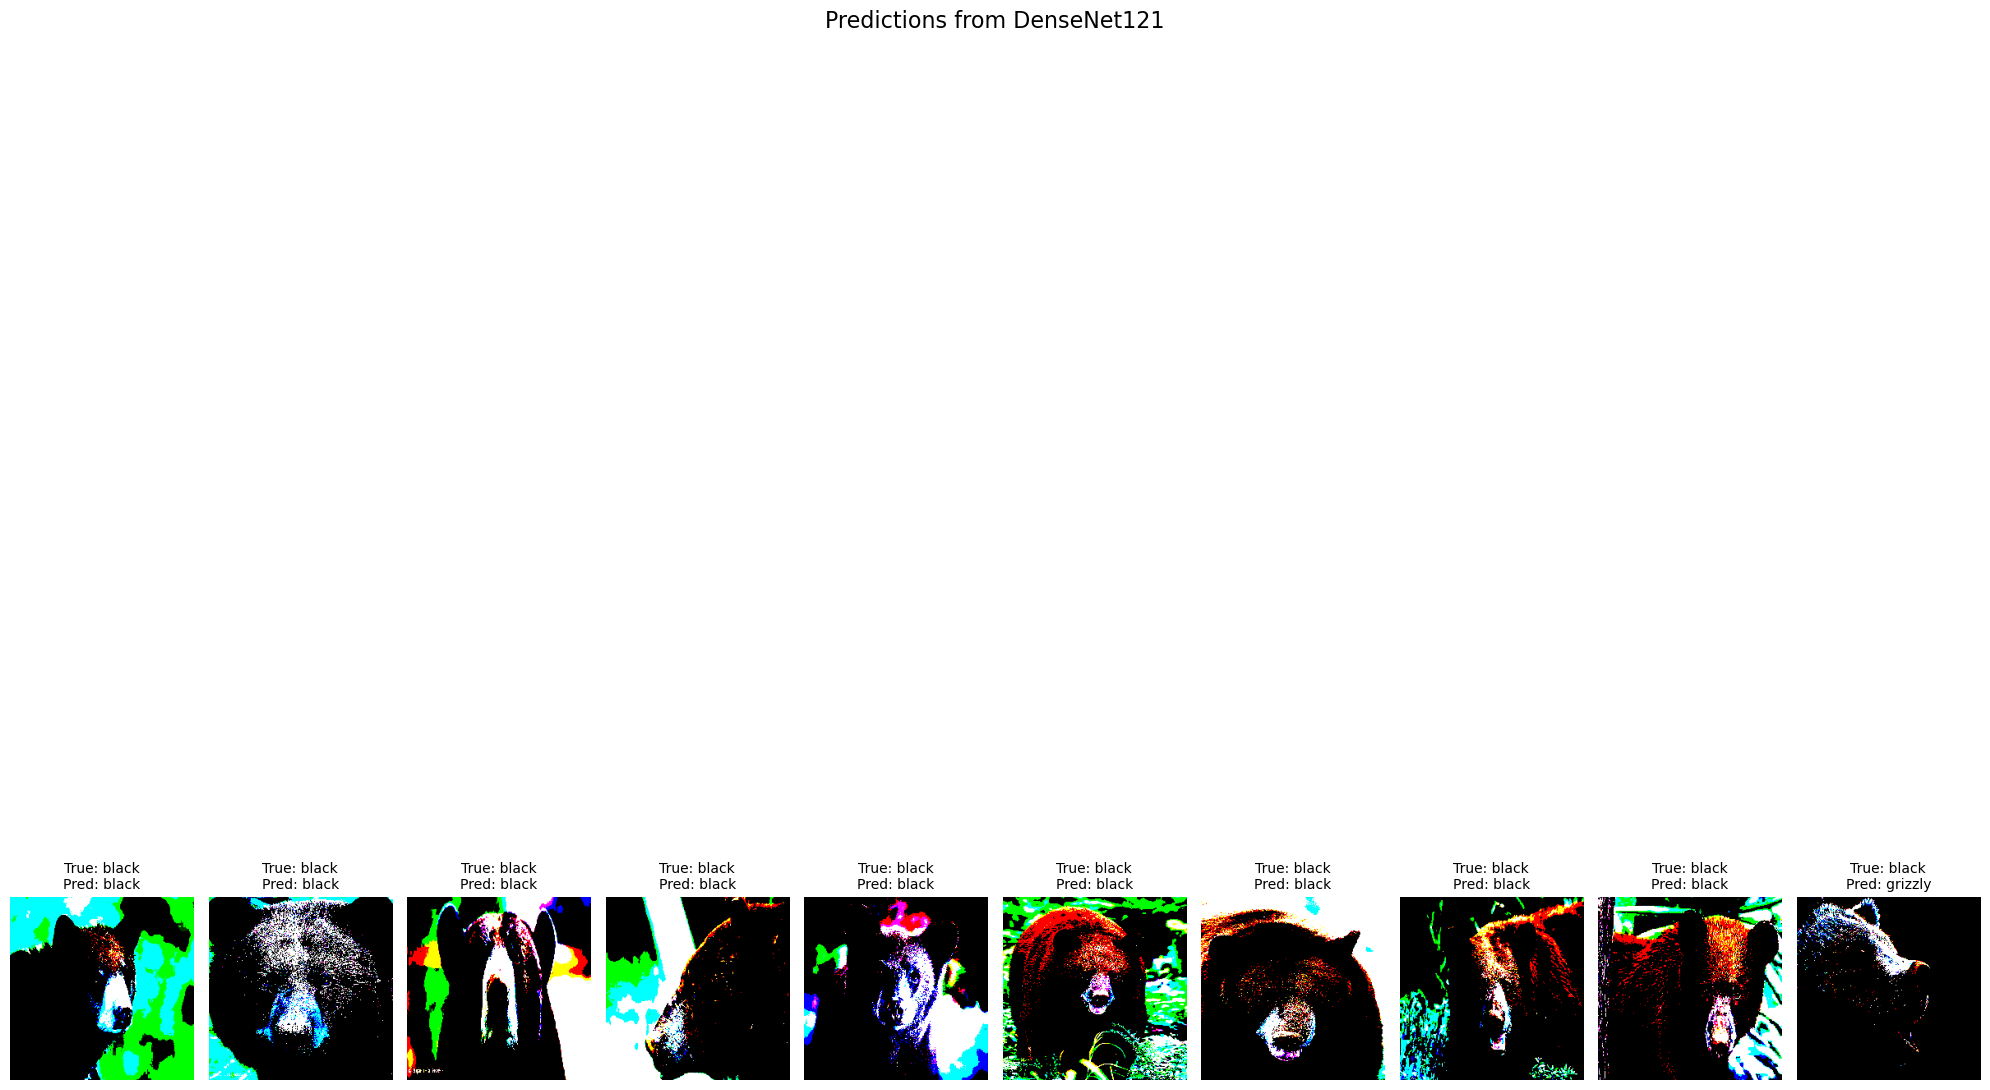

In [45]:
y_pred = densenet_final_model.predict(test_imgs)
y_pred_densenet_labels = np.argmax(y_pred, axis=1)
plotImagesWithPredictions(test_imgs, 
                          [class_names[i] for i in true_labels], 
                          [class_names[i] for i in y_pred_densenet_labels], 
                          model_name="DenseNet121")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


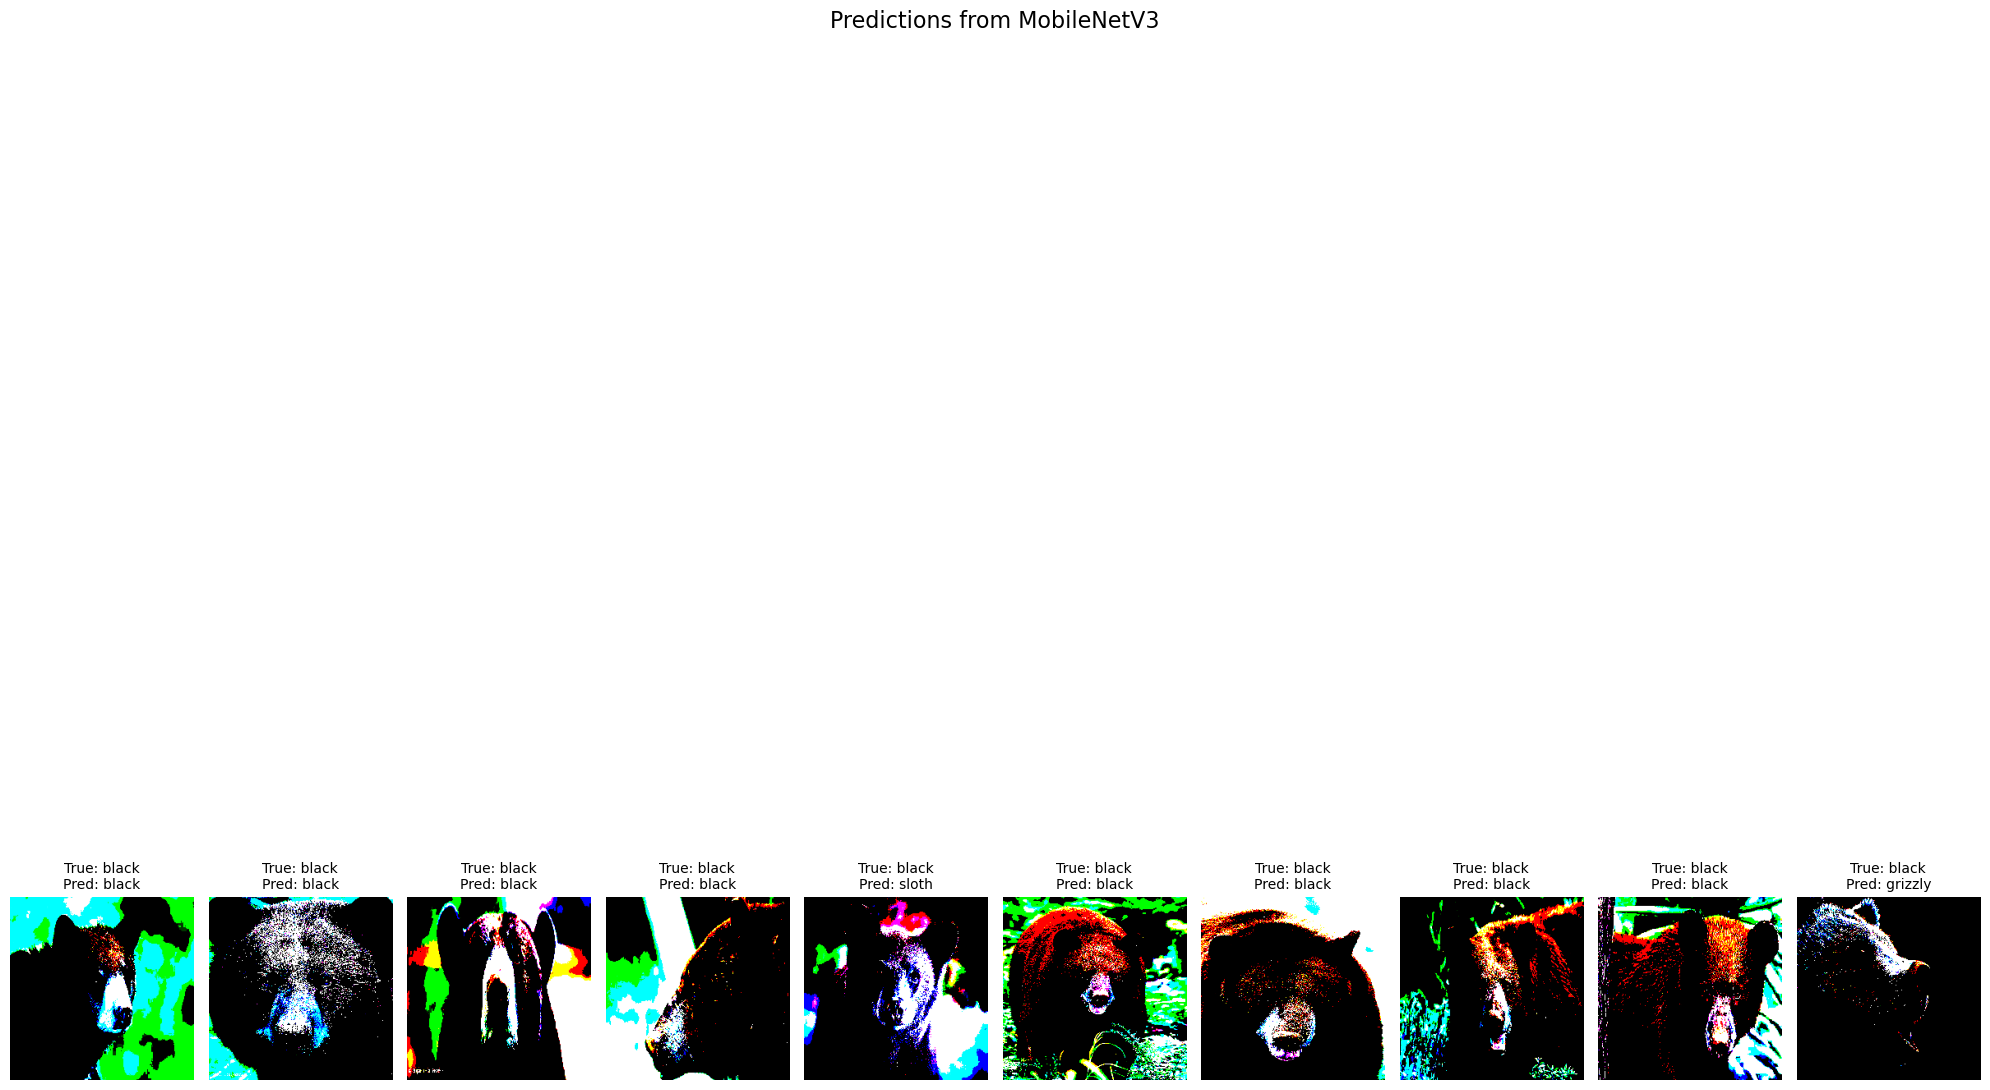

In [36]:
y_pred = mobilenet_final_model.predict(test_imgs)
y_pred_mobilenet_labels = np.argmax(y_pred, axis=1)
plotImagesWithPredictions(test_imgs, 
                          [class_names[i] for i in true_labels], 
                          [class_names[i] for i in y_pred_mobilenet_labels], 
                          model_name="MobileNetV3")

In [46]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

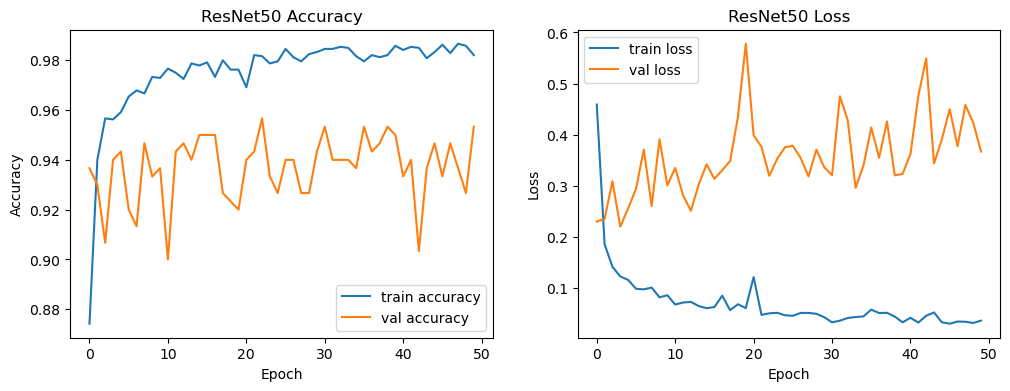

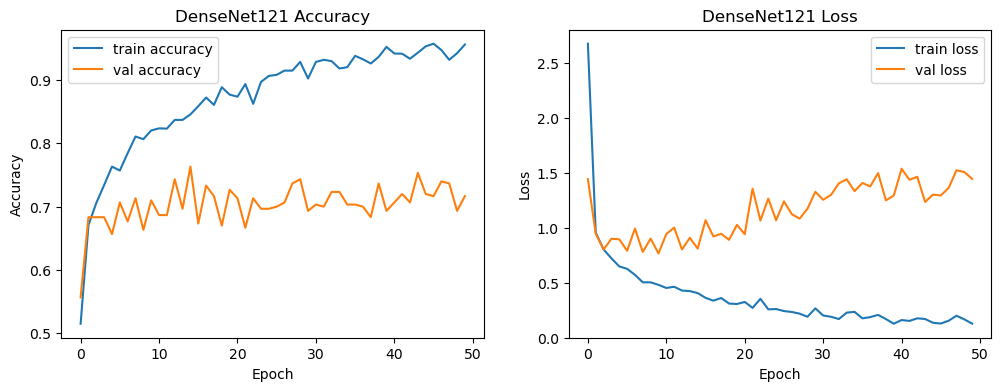

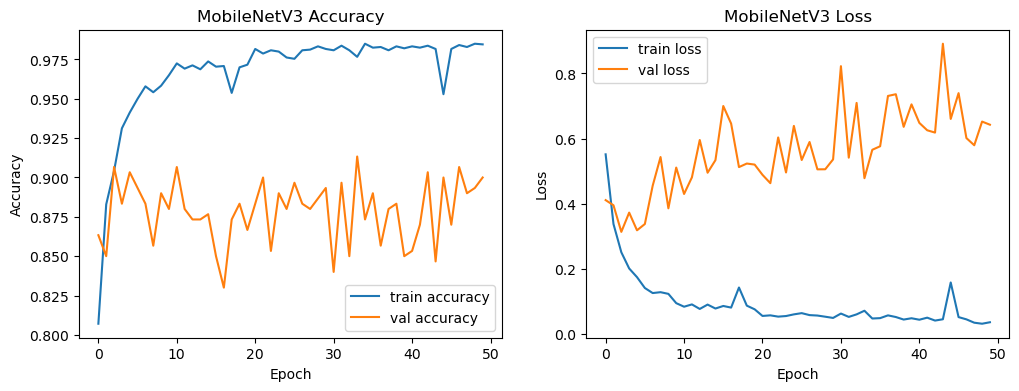

In [47]:
plot_history(resnet_history, "ResNet50")
plot_history(densenet_history, "DenseNet121")
plot_history(history_mobilenet, "MobileNetV3")

<h2

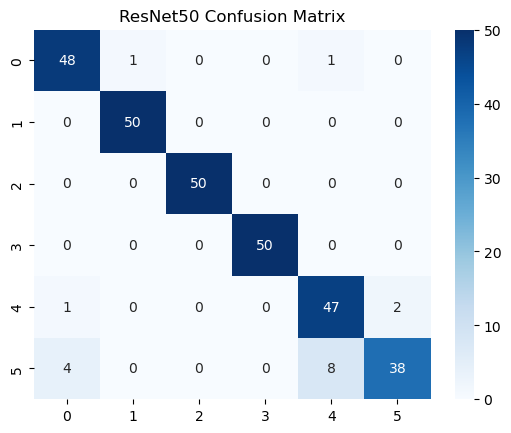

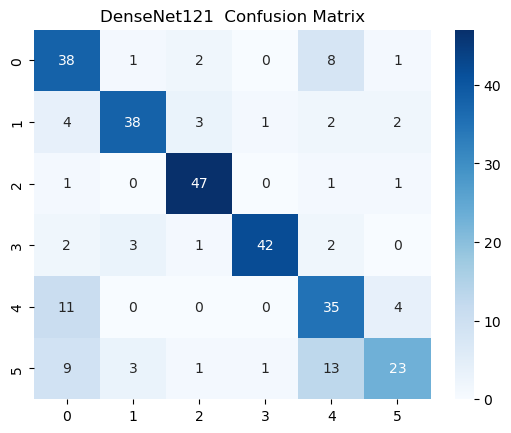

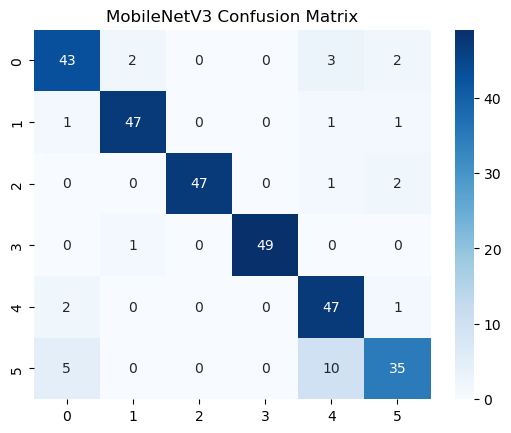

In [48]:
#ResNet50
conf_matrix_resnet = confusion_matrix(y_true, y_pred_resnet)
sns.heatmap(conf_matrix_resnet, annot=True, fmt='d', cmap='Blues')
plt.title("ResNet50 Confusion Matrix")
plt.show()

# DenseNet121
conf_matrix_densenet = confusion_matrix(y_true, y_pred_densenet)
sns.heatmap(conf_matrix_densenet, annot=True, fmt='d', cmap='Blues')
plt.title("DenseNet121  Confusion Matrix")
plt.show()


# MobileNetV3
conf_matrix_mobilenet = confusion_matrix(y_true, y_pred_mobilenet)
sns.heatmap(conf_matrix_mobilenet, annot=True, fmt='d', cmap='Blues')
plt.title("MobileNetV3 Confusion Matrix")
plt.show()

In [49]:
import pandas as pd

# Use recorded training times
# Ensure these values are dynamically updated after training
training_time_resnet = resnet_history_dict.get("training_time", 0)  # Recorded during ResNet training
training_time_densenet = densenet_history_dict.get("training_time", 0)  # Recorded during DenseNet training
training_time_mobilenet = mobilenet_history_dict.get("training_time", 0)  # Recorded during MobileNet training

# Store metrics for comparison
models_comparison = {
    "Model": ["ResNet50", "DenseNet121", "MobileNetV3"],
    "Accuracy": [test_accuracy_resnet, test_accuracy_densenet, test_accuracy_mobilenet],
    "Test Loss": [test_loss_resnet, test_loss_densenet, test_loss_mobilenet],
    "mAP": [mAP, mAP_densenet, mAP_mobilenet],
    "Training Time (s)": [training_time_resnet, training_time_densenet, training_time_mobilenet],
    "Parameters": [
        resnet_final_model.count_params(),
        densenet_final_model.count_params(),
        mobilenet_final_model.count_params()
    ]
}

# Create a DataFrame
results_df = pd.DataFrame(models_comparison)

# Display the results DataFrame
print("Model Comparison Results:")
print(results_df)

# Identify the best model based on accuracy
best_model = results_df.loc[results_df['Accuracy'].idxmax()]
print("\nBest Model Based on Accuracy:")
print(best_model)

# Identify the best model based on mAP
best_model_map = results_df.loc[results_df['mAP'].idxmax()]
print("\nBest Model Based on mAP:")
print(best_model_map)

# Optionally, identify the fastest training model
fastest_model = results_df.loc[results_df['Training Time (s)'].idxmin()]
print("\nFastest Training Model:")
print(fastest_model)


Model Comparison Results:
         Model  Accuracy  Test Loss       mAP  Training Time (s)  Parameters
0     ResNet50  0.943333   0.424865  0.970664        2351.291426    25692038
1  DenseNet121  0.743333   1.670044  0.784534        3212.043813     8093254
2  MobileNetV3  0.893333   0.673178  0.939314        1219.770741     1536118

Best Model Based on Accuracy:
Model                   ResNet50
Accuracy                0.943333
Test Loss               0.424865
mAP                     0.970664
Training Time (s)    2351.291426
Parameters              25692038
Name: 0, dtype: object

Best Model Based on mAP:
Model                   ResNet50
Accuracy                0.943333
Test Loss               0.424865
mAP                     0.970664
Training Time (s)    2351.291426
Parameters              25692038
Name: 0, dtype: object

Fastest Training Model:
Model                MobileNetV3
Accuracy                0.893333
Test Loss               0.673178
mAP                     0.939314
Training T